##### Imports

In [83]:
# Parameters
top = 10  # default value

In [84]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [85]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [87]:
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

In [88]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.keys())

['/us_equities/stocks', '/stooq/us/nyse/stocks/prices', '/stooq/us/nyse/stocks/tickers', '/stooq/us/nyse/etfs/prices', '/stooq/us/nyse/etfs/tickers', '/stooq/us/nasdaq/stocks/prices', '/stooq/us/nasdaq/stocks/tickers', '/stooq/us/nasdaq/etfs/prices', '/stooq/us/nasdaq/etfs/tickers', '/sp500/fred_price', '/sp500/stocks_name', '/factor/top250_dataset_alpha101', '/factor/top250_dataset_with_TA', '/factor/top250_dataset_with_rolling_beta_size_proxy', '/factor/top500_dataset_alpha101', '/factor/top500_dataset_with_TA', '/factor/top500_dataset_with_rolling_beta_size_proxy', '/factor/top{top}_dataset_alpha101', '/data/top10_dataset', '/data/top250_dataset', '/data/top500_dataset']


In [89]:
with pd.HDFStore(DATA_STORE) as store:
    nyse_stocks = store['/stooq/us/nyse/stocks/prices']
    nasdaq_stocks = store['/stooq/us/nasdaq/stocks/prices']
    metadata = store['us_equities/stocks'].loc[:, ['market cap', 'sector']]

In [90]:
# Concatenate the two DataFrames
data = pd.concat([nyse_stocks, nasdaq_stocks])

# Drop NaN values and duplicates
data = data.dropna().drop_duplicates()

# Display the cleaned DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11958377 entries, ('', Timestamp('2013-01-02 00:00:00')) to ('ZYXI', Timestamp('2023-08-11 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 502.2+ MB
None


In [91]:
metadata.sector = pd.factorize(metadata.sector)[0]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7516 entries, AACG to ZWS
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   market cap  7078 non-null   float64
 1   sector      7516 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 176.2+ KB


In [92]:
data = data.join(metadata).dropna(subset=['sector'])

In [93]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 6,700 | # Dates: 2,671


In [94]:
# Identifying duplicate entries based on index
duplicates = data[data.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [open, high, low, close, volume, market cap, sector]
Index: []


##### Select 500 most-traded stocks

In [95]:
dv = data.close.mul(data.volume)
dv = dv[~dv.index.duplicated(keep='first')]

In [96]:
# locals()[f'top{top}'] = (dv.groupby(level='date')
#                          .rank(ascending=False)
#                          .unstack('ticker')
#                          .dropna(thresh=8*252, axis=1)
#                          .mean()
#                          .nsmallest(top))


selected_tickers = (dv.groupby(level='date')
                    .rank(ascending=False)
                    .unstack('ticker')
                    .dropna(thresh=8*252, axis=1)
                    .mean()
                    .nsmallest(top))

##### Visualize the 200 most liquid stocks

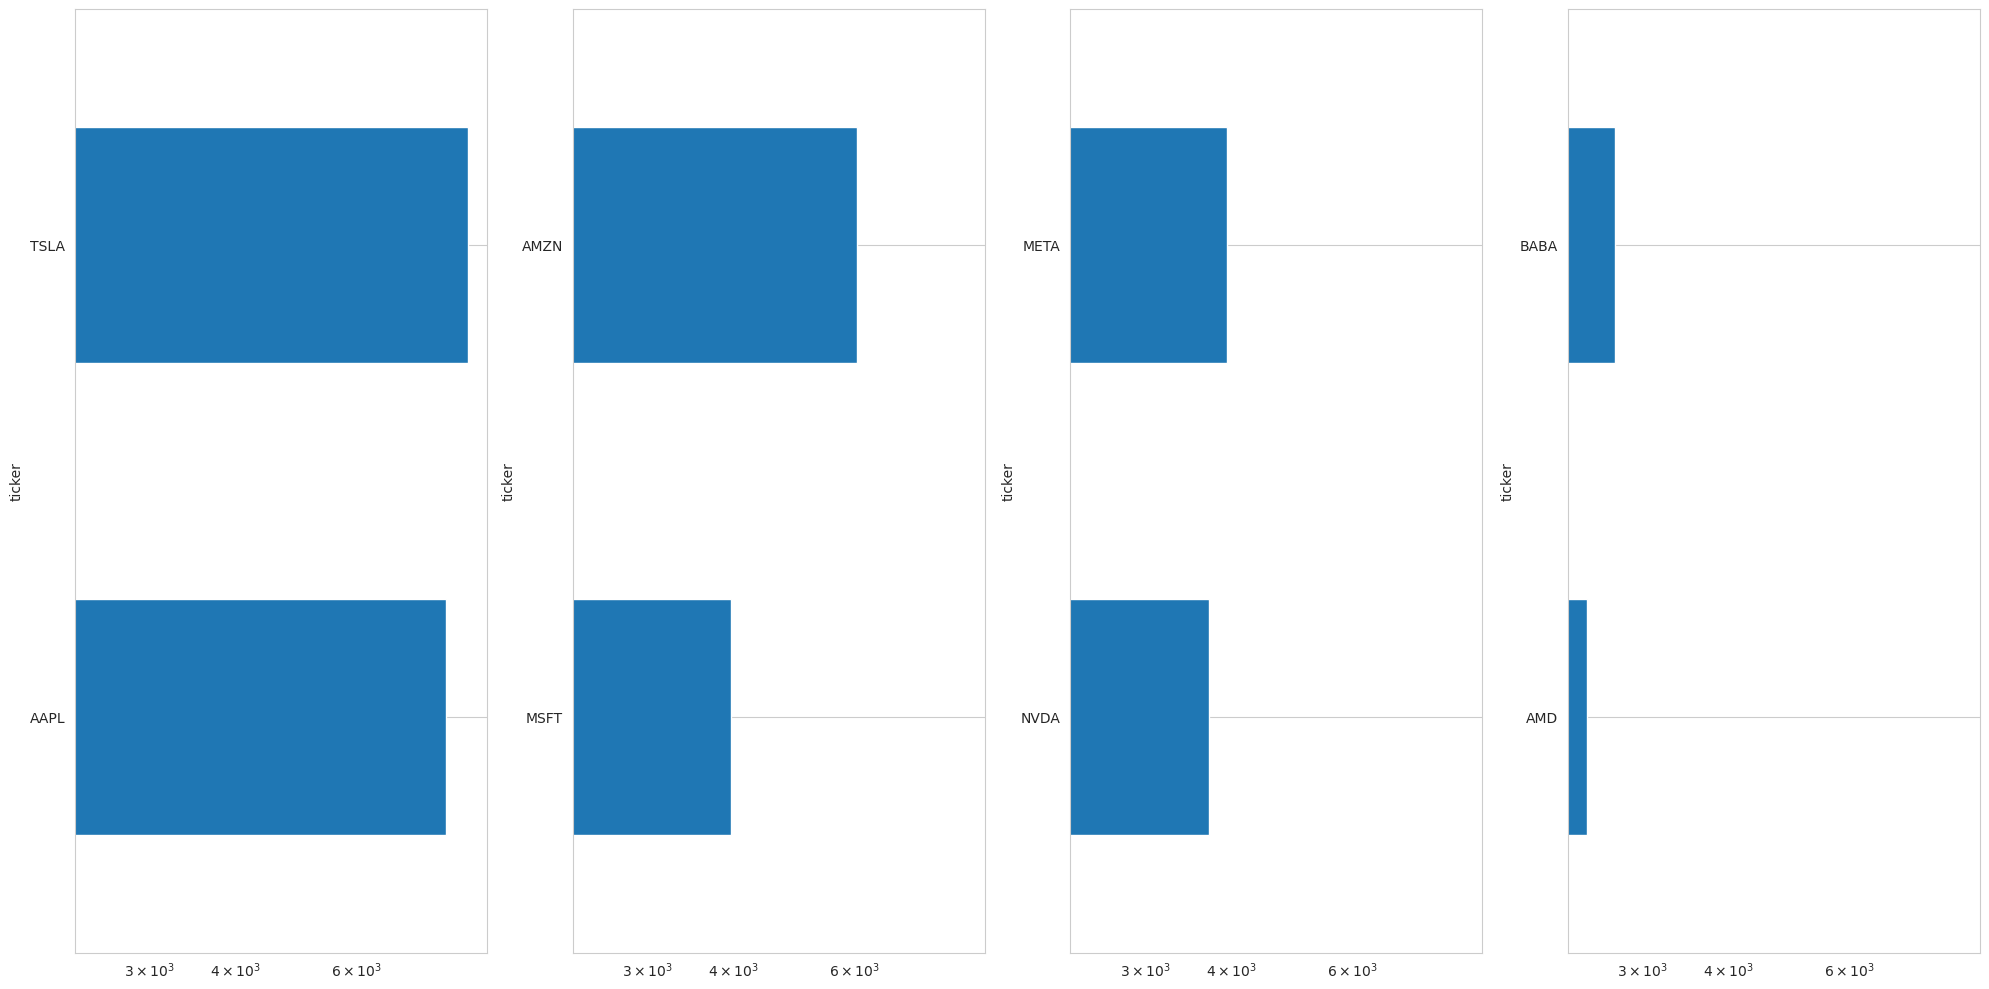

In [97]:
# dv = data.close.mul(data.volume).div(1e6)  # scaling values to millions
# dv = dv[~dv.index.duplicated(keep='first')]

# # Group by date and ticker, then by ticker alone
# avg_dv_per_ticker = dv.groupby(level=['date', 'ticker']).mean().groupby(level='ticker').mean()

# # Get top 200 tickers based on the average dollar volume
# top200_tickers = avg_dv_per_ticker.nlargest(200)

# cutoffs = [0, 50, 100, 150, 200]
# fig, axes = plt.subplots(ncols=4, figsize=(20, 10), sharex=True)
# axes = axes.flatten()

# for i, cutoff in enumerate(cutoffs[1:], 1):
#     top200_tickers.iloc[cutoffs[i-1]:cutoffs[i]].sort_values().plot.barh(logx=True, ax=axes[i-1])

# fig.tight_layout()


dv = data.close.mul(data.volume).div(1e6)  # scaling values to millions
dv = dv[~dv.index.duplicated(keep='first')]

# Group by date and ticker, then by ticker alone
avg_dv_per_ticker = dv.groupby(level=['date', 'ticker']).mean().groupby(level='ticker').mean()

# Get top 'top' tickers based on the average dollar volume
top_tickers = avg_dv_per_ticker.nlargest(top)

# Dynamically determine cutoffs based on the top value
step = top // 4
cutoffs = [i for i in range(0, top, step)]
fig, axes = plt.subplots(ncols=len(cutoffs)-1, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, cutoff in enumerate(cutoffs[1:], 1):
    top_tickers.iloc[cutoffs[i-1]:cutoffs[i]].sort_values().plot.barh(logx=True, ax=axes[i-1])

fig.tight_layout()

In [98]:
to_drop = data.index.unique('ticker').difference(selected_tickers.index)

In [99]:
len(to_drop)

6690

In [100]:
data = data.drop(to_drop, level='ticker')

In [101]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25968 entries, ('BABA', Timestamp('2014-09-19 00:00:00')) to ('NFLX', Timestamp('2023-08-11 00:00:00'))
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        25968 non-null  float64
 1   high        25968 non-null  float64
 2   low         25968 non-null  float64
 3   close       25968 non-null  float64
 4   volume      25968 non-null  float64
 5   market cap  25968 non-null  float64
 6   sector      25968 non-null  float64
dtypes: float64(7)
memory usage: 1.9+ MB


In [102]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 10 | # Dates: 2,671


##### Remove outlier observations based on daily returns

In [103]:
before = len(data)
data['ret'] = data.groupby('ticker').close.pct_change()
data = data[data.ret.between(-1, 1)].drop('ret', axis=1)
print(f'Dropped {before-len(data):,.0f}')

Dropped 10


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25958 entries, ('BABA', Timestamp('2014-09-22 00:00:00')) to ('NFLX', Timestamp('2023-08-11 00:00:00'))
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        25958 non-null  float64
 1   high        25958 non-null  float64
 2   low         25958 non-null  float64
 3   close       25958 non-null  float64
 4   volume      25958 non-null  float64
 5   market cap  25958 non-null  float64
 6   sector      25958 non-null  float64
dtypes: float64(7)
memory usage: 1.9+ MB


In [105]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df, ticker):
    # Extract relevant data for the ticker
    ticker_data = df.loc[ticker]
    
    # Ensure data covers at least 2 years, otherwise return a message
    if len(ticker_data) < 2 * 252:  # Assuming 252 trading days in a year
        return f"Insufficient data for {ticker}. Need at least 2 years of data."

    # Calculate log and percentage returns
    ticker_data['log_ret'] = np.log(ticker_data['close'] / ticker_data['close'].shift(1))
    ticker_data['pct_ret'] = ticker_data['close'].pct_change()

    # Drop NaN values (the first row after computing returns)
    ticker_data = ticker_data.dropna()

    # Test stationarity for each series using ADF
    adf_price = adfuller(ticker_data['close'])
    adf_log_ret = adfuller(ticker_data['log_ret'])
    adf_pct_ret = adfuller(ticker_data['pct_ret'])
    
    # Store results in a dictionary for comparison
    results = {
        'price': adf_price[0],
        'log_ret': adf_log_ret[0],
        'pct_ret': adf_pct_ret[0]
    }
    # Find which series is the most stationary based on the ADF statistic (the lower, the better)
    most_stationary = min(results, key=results.get)
    
    return most_stationary, results

# Example usage:
ticker = 'AAPL'  # Replace with desired ticker
most_stationary, results = test_stationarity(data, ticker)
print(f"For {ticker}, the most stationary series is: {most_stationary}.")
print("ADF Results:", results)

For AAPL, the most stationary series is: pct_ret.
ADF Results: {'price': 0.4633927548084181, 'log_ret': -16.492797724238496, 'pct_ret': -16.585440873113704}


In [106]:
tickers = data.index.unique('ticker')
print(f"# Tickers: {len(tickers):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 10 | # Dates: 2,670


##### Compute returns
- Frac diff

In [107]:
import numpy as np
import pandas as pd
from tsfracdiff import FractionalDifferentiator

def process_tickers(df, num_tickers=None):
    processed_dfs = []

    # If num_tickers is not provided, process all tickers
    if num_tickers is None:
        ticker_groups = list(df.groupby(level=0))
    else:
        ticker_groups = list(df.groupby(level=0))[:num_tickers]

    for ticker, group in ticker_groups:
        group_copy = group.copy()

        # Calculate X_frac 
        frac_diff = FractionalDifferentiator()
        X_frac = frac_diff.FitTransform(group_copy[['close']])
    
        # The number of NaN values needed to align X_frac with close
        nans_needed = len(group_copy) - len(X_frac)

        # Create a NaN series of required length
        nan_series = pd.Series([np.nan] * nans_needed)

        # Append the NaN series to the start of X_frac
        X_frac_aligned = nan_series.append(X_frac['close']).reset_index(drop=True)

        # Add the aligned X_frac to the group
        column_name = f"ret_frac_order"
        group_copy[column_name] = X_frac_aligned.values

        processed_dfs.append(group_copy)

    # Concatenate all processed dataframes
    result_df = pd.concat(processed_dfs)

    return result_df

# Process all tickers
data = process_tickers(data.copy())

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25958 entries, ('AAPL', Timestamp('2013-01-03 00:00:00')) to ('NFLX', Timestamp('2023-08-11 00:00:00'))
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            25958 non-null  float64
 1   high            25958 non-null  float64
 2   low             25958 non-null  float64
 3   close           25958 non-null  float64
 4   volume          25958 non-null  float64
 5   market cap      25958 non-null  float64
 6   sector          25958 non-null  float64
 7   ret_frac_order  22515 non-null  float64
dtypes: float64(8)
memory usage: 1.7+ MB


In [109]:
data

open      high       low     close        volume  \
ticker date                                                               
AAPL   2013-01-03   16.8177   16.8835   16.6173   16.6502  4.100891e+08   
       2013-01-04   16.4927   16.5446   16.1497   16.1876  6.906772e+08   
       2013-01-07   16.0331   16.2554   15.8247   16.0899  5.625061e+08   
       2013-01-08   16.2534   16.3362   16.0101   16.1338  5.327635e+08   
       2013-01-09   16.0531   16.1249   15.8486   15.8826  4.737067e+08   
...                     ...       ...       ...       ...           ...   
NFLX   2023-08-07  436.4550  441.1100  428.9057  440.7600  4.781303e+06   
       2023-08-08  440.3600  443.5700  435.1000  438.3000  3.767195e+06   
       2023-08-09  439.7400  440.6200  427.5900  428.9000  3.846639e+06   
       2023-08-10  431.1200  438.1200  428.6900  429.9800  5.467607e+06   
       2023-08-11  428.9800  430.6317  421.3277  421.6600  3.927914e+06   

                     market cap  sector  ret_frac_order  
ticker date                                              
AAPL   2013-01-03  2.779610e+12     3.0             NaN  
       2013-01-04  2.779610e+12     3.0             NaN  
       2013-01-07  2.779610e+12     3.0             NaN  
       2013-01-08  2.779610e+12     3.0             NaN  
       2013-01-09  2.779610e+12     3.0             NaN  
...                         ...     ...             ...  
NFLX   2023-08-07  1.868573e+11     0.0       82.512386  
       2023-08-08  1.868573e+11     0.0       77.302142  
       2023-08-09  1.868573e+11     0.0       67.576440  
       2023-08-10  1.868573e+11     0.0       70.992506  
       2023-08-11  1.868573e+11     0.0       63.007997  

[25958 rows x 8 columns]

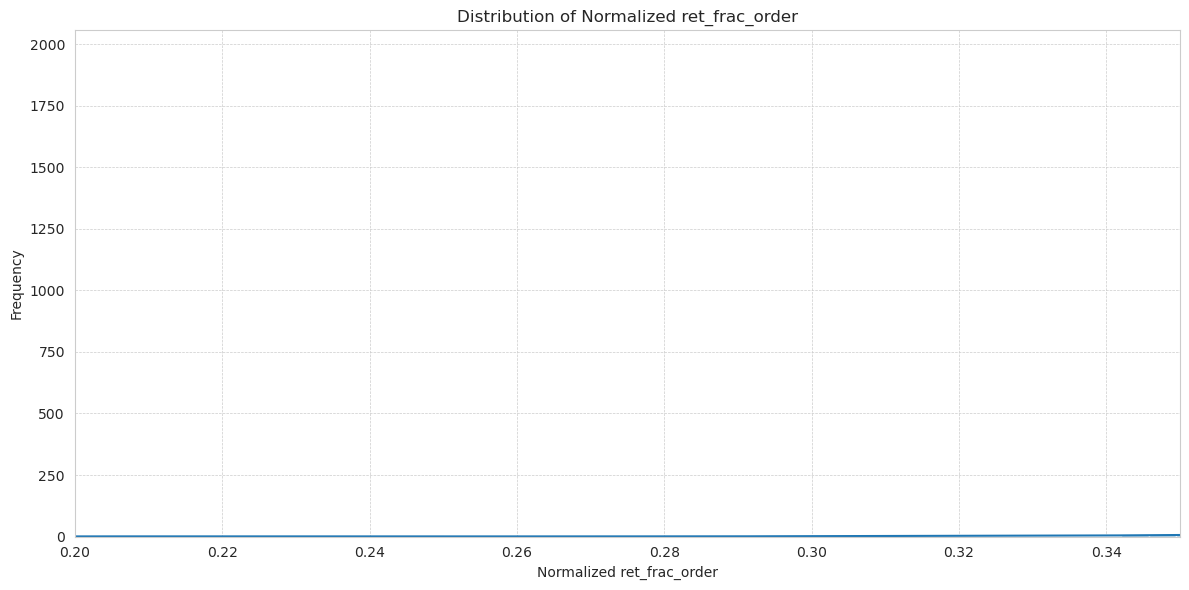

In [110]:
# Removing NaN values from 'ret_frac_order' for the analysis
data_filtered = data['ret_frac_order'].dropna()

# Normalize the data
data_min = data_filtered.min()
data_max = data_filtered.max()
normalized_data = (data_filtered - data_min) \
    / (data_max - data_min)

# Plot the distribution of the normalized data
plt.figure(figsize=(12, 6))

# Adjust the x-scale
plt.xlim(0.20, 0.35)

sns.histplot(normalized_data, bins="auto", kde=True)
plt.title('Distribution of Normalized ret_frac_order')
plt.xlabel('Normalized ret_frac_order')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

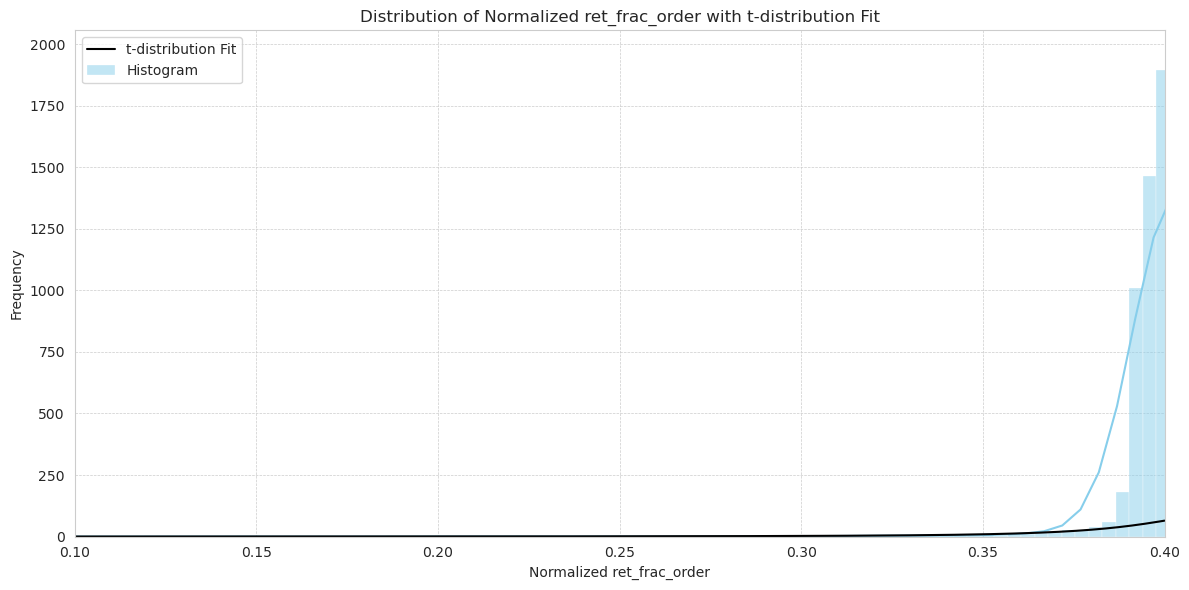

In [111]:
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Removing NaN values from 'ret_frac_order' for the analysis
data_filtered = data['ret_frac_order'].dropna()

# Normalize the data
data_min = data_filtered.min()
data_max = data_filtered.max()
normalized_data = (data_filtered - data_min) \
    / (data_max - data_min)

# Fit a t-distribution to the data
params = t.fit(normalized_data)

# Plot the histogram of the data
plt.figure(figsize=(12, 6))
sns.histplot(normalized_data, bins="auto", kde=True, color="skyblue", label="Histogram")
plt.title('Distribution of Normalized ret_frac_order with t-distribution Fit')
plt.xlabel('Normalized ret_frac_order')
plt.ylabel('Frequency')

# Adjust the x-scale
plt.xlim(0.1, 0.4)

# Overlay the fitted t-distribution
x = np.linspace(0.1, 0.4, 1000)
pdf_fitted = t.pdf(x, *params)
plt.plot(x, pdf_fitted * len(normalized_data) * (x[1] - x[0]), '-k', label="t-distribution Fit")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

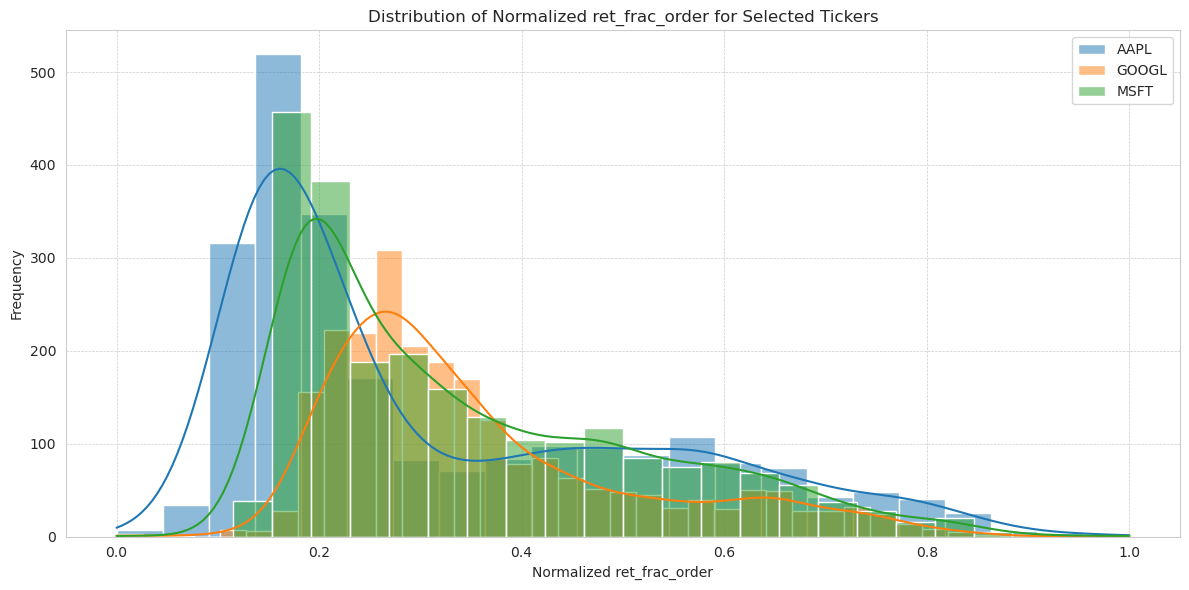

In [112]:
# Define the tickers for which you want to plot the distribution
tickers_to_plot = ['AAPL', 'GOOGL', 'MSFT']  # example tickers

plt.figure(figsize=(12, 6))

# Loop through each ticker and plot the distribution
for ticker in tickers_to_plot:
    # Filter the data for the specified ticker
    ticker_data = data_filtered.loc[ticker]
    
    # Normalize the ticker_data
    data_min = ticker_data.min()
    data_max = ticker_data.max()
    normalized_ticker_data = (ticker_data - data_min) / (data_max - data_min)

    # Plot the distribution of the normalized data for the given ticker
    sns.histplot(normalized_ticker_data, bins="auto", kde=True, label=ticker)

plt.title(f'Distribution of Normalized ret_frac_order for Selected Tickers')
plt.xlabel('Normalized ret_frac_order')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

- Historical returns

In [113]:
T = [1, 2, 3, 4, 5, 10, 21, 42, 63, 126, 252]

by_ticker = data.groupby(level='ticker')

for t in T:
    col_name = f'ret_{t:02}d'
    data[col_name] = by_ticker.close.pct_change(t)
    
    # Fill NaN values in the column using forward fill, followed by backward fill
    data[col_name] = data[col_name].fillna(method='ffill').fillna(method='bfill')

In [114]:
data

open      high       low     close        volume  \
ticker date                                                               
AAPL   2013-01-03   16.8177   16.8835   16.6173   16.6502  4.100891e+08   
       2013-01-04   16.4927   16.5446   16.1497   16.1876  6.906772e+08   
       2013-01-07   16.0331   16.2554   15.8247   16.0899  5.625061e+08   
       2013-01-08   16.2534   16.3362   16.0101   16.1338  5.327635e+08   
       2013-01-09   16.0531   16.1249   15.8486   15.8826  4.737067e+08   
...                     ...       ...       ...       ...           ...   
NFLX   2023-08-07  436.4550  441.1100  428.9057  440.7600  4.781303e+06   
       2023-08-08  440.3600  443.5700  435.1000  438.3000  3.767195e+06   
       2023-08-09  439.7400  440.6200  427.5900  428.9000  3.846639e+06   
       2023-08-10  431.1200  438.1200  428.6900  429.9800  5.467607e+06   
       2023-08-11  428.9800  430.6317  421.3277  421.6600  3.927914e+06   

                     market cap  sector  ret_frac_order   ret_01d   ret_02d  \
ticker date                                                                   
AAPL   2013-01-03  2.779610e+12     3.0             NaN -0.027783 -0.033651   
       2013-01-04  2.779610e+12     3.0             NaN -0.027783 -0.033651   
       2013-01-07  2.779610e+12     3.0             NaN -0.006035 -0.033651   
       2013-01-08  2.779610e+12     3.0             NaN  0.002728 -0.003324   
       2013-01-09  2.779610e+12     3.0             NaN -0.015570 -0.012884   
...                         ...     ...             ...       ...       ...   
NFLX   2023-08-07  1.868573e+11     0.0       82.512386  0.021223  0.022645   
       2023-08-08  1.868573e+11     0.0       77.302142 -0.005581  0.015524   
       2023-08-09  1.868573e+11     0.0       67.576440 -0.021446 -0.026908   
       2023-08-10  1.868573e+11     0.0       70.992506  0.002518 -0.018982   
       2023-08-11  1.868573e+11     0.0       63.007997 -0.019350 -0.016880   

                    ret_03d   ret_04d   ret_05d   ret_10d   ret_21d   ret_42d  \
ticker date                                                                     
AAPL   2013-01-03 -0.031015 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
       2013-01-04 -0.031015 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
       2013-01-07 -0.031015 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
       2013-01-08 -0.031015 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
       2013-01-09 -0.018842 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
...                     ...       ...       ...       ...       ...       ...   
NFLX   2023-08-07  0.025739  0.004879  0.004078  0.028924  0.006072  0.103859   
       2023-08-08  0.016937  0.020014 -0.000730  0.024784 -0.007720  0.096380   
       2023-08-09 -0.006256 -0.004872 -0.001862  0.014740 -0.025692  0.047707   
       2023-08-10 -0.024458 -0.003753 -0.002367  0.040685 -0.031686  0.023713   
       2023-08-11 -0.037965 -0.043334 -0.023031 -0.009676 -0.063768 -0.005448   

                    ret_63d  ret_126d  ret_252d  
ticker date                                      
AAPL   2013-01-03 -0.214778 -0.220466  0.022931  
       2013-01-04 -0.214778 -0.220466  0.022931  
       2013-01-07 -0.214778 -0.220466  0.022931  
       2013-01-08 -0.214778 -0.220466  0.022931  
       2013-01-09 -0.214778 -0.220466  0.022931  
...                     ...       ...       ...  
NFLX   2023-08-07  0.365597  0.204591  0.917098  
       2023-08-08  0.323330  0.212515  0.932710  
       2023-08-09  0.291323  0.181705  0.836910  
       2023-08-10  0.281915  0.172151  0.869966  
       2023-08-11  0.223054  0.163200  0.727336  

[25958 rows x 19 columns]

##### Forward returns

In [115]:
# Create forward shifted column
data['ret_fwd_frac_order'] = data['ret_frac_order'].shift(-1)

# Fill NaN values using forward fill
data['ret_fwd_frac_order'].fillna(method='ffill', inplace=True)

In [116]:
T = [1, 2, 3, 4, 5, 10, 21, 42, 63, 126, 252]

by_ticker = data.groupby(level='ticker')

# Create forward shifted columns for each t in T
for t in T:
    col_name = f'ret_fwd_{t:02}d'
    data[col_name] = by_ticker[f'ret_{t:02}d'].shift(-1)
    
#     # Fill NaN values in the forward shifted column using forward fill, followed by backward fill
#     data[col_name] = data[col_name].fillna(method='ffill').fillna(method='bfill')

# # If after filling there are still rows with NaN values that you wish to drop (which might be rare after both fill methods):
# data = data.dropna(subset=[f'ret_fwd_{t:02}d' for t in T])

In [117]:
data

open      high       low     close        volume  \
ticker date                                                               
AAPL   2013-01-03   16.8177   16.8835   16.6173   16.6502  4.100891e+08   
       2013-01-04   16.4927   16.5446   16.1497   16.1876  6.906772e+08   
       2013-01-07   16.0331   16.2554   15.8247   16.0899  5.625061e+08   
       2013-01-08   16.2534   16.3362   16.0101   16.1338  5.327635e+08   
       2013-01-09   16.0531   16.1249   15.8486   15.8826  4.737067e+08   
...                     ...       ...       ...       ...           ...   
NFLX   2023-08-07  436.4550  441.1100  428.9057  440.7600  4.781303e+06   
       2023-08-08  440.3600  443.5700  435.1000  438.3000  3.767195e+06   
       2023-08-09  439.7400  440.6200  427.5900  428.9000  3.846639e+06   
       2023-08-10  431.1200  438.1200  428.6900  429.9800  5.467607e+06   
       2023-08-11  428.9800  430.6317  421.3277  421.6600  3.927914e+06   

                     market cap  sector  ret_frac_order   ret_01d   ret_02d  \
ticker date                                                                   
AAPL   2013-01-03  2.779610e+12     3.0             NaN -0.027783 -0.033651   
       2013-01-04  2.779610e+12     3.0             NaN -0.027783 -0.033651   
       2013-01-07  2.779610e+12     3.0             NaN -0.006035 -0.033651   
       2013-01-08  2.779610e+12     3.0             NaN  0.002728 -0.003324   
       2013-01-09  2.779610e+12     3.0             NaN -0.015570 -0.012884   
...                         ...     ...             ...       ...       ...   
NFLX   2023-08-07  1.868573e+11     0.0       82.512386  0.021223  0.022645   
       2023-08-08  1.868573e+11     0.0       77.302142 -0.005581  0.015524   
       2023-08-09  1.868573e+11     0.0       67.576440 -0.021446 -0.026908   
       2023-08-10  1.868573e+11     0.0       70.992506  0.002518 -0.018982   
       2023-08-11  1.868573e+11     0.0       63.007997 -0.019350 -0.016880   

                    ret_03d   ret_04d   ret_05d   ret_10d   ret_21d   ret_42d  \
ticker date                                                                     
AAPL   2013-01-03 -0.031015 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
       2013-01-04 -0.031015 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
       2013-01-07 -0.031015 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
       2013-01-08 -0.031015 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
       2013-01-09 -0.018842 -0.046102 -0.034432 -0.072690 -0.184058 -0.210286   
...                     ...       ...       ...       ...       ...       ...   
NFLX   2023-08-07  0.025739  0.004879  0.004078  0.028924  0.006072  0.103859   
       2023-08-08  0.016937  0.020014 -0.000730  0.024784 -0.007720  0.096380   
       2023-08-09 -0.006256 -0.004872 -0.001862  0.014740 -0.025692  0.047707   
       2023-08-10 -0.024458 -0.003753 -0.002367  0.040685 -0.031686  0.023713   
       2023-08-11 -0.037965 -0.043334 -0.023031 -0.009676 -0.063768 -0.005448   

                    ret_63d  ret_126d  ret_252d  ret_fwd_frac_order  \
ticker date                                                           
AAPL   2013-01-03 -0.214778 -0.220466  0.022931                 NaN   
       2013-01-04 -0.214778 -0.220466  0.022931                 NaN   
       2013-01-07 -0.214778 -0.220466  0.022931                 NaN   
       2013-01-08 -0.214778 -0.220466  0.022931                 NaN   
       2013-01-09 -0.214778 -0.220466  0.022931                 NaN   
...                     ...       ...       ...                 ...   
NFLX   2023-08-07  0.365597  0.204591  0.917098           77.302142   
       2023-08-08  0.323330  0.212515  0.932710           67.576440   
       2023-08-09  0.291323  0.181705  0.836910           70.992506   
       2023-08-10  0.281915  0.172151  0.869966           63.007997   
       2023-08-11  0.223054  0.163200  0.727336           63.007997   

                   ret_fwd_01d  ret_fwd_0

##### Persist results

In [118]:
import pandas as pd
import gc
from utils import optimize_dataframe


data.rename(columns={'market cap': \
    'market_cap'}, inplace=True)

df_optimized = optimize_dataframe(data.copy())

Data memory before optimization: 6.30 MB
Data memory after optimization: 3.43 MB
Reduced by: 45.60%


In [119]:
df_optimized

open        high         low       close  \
ticker date                                                         
AAPL   2013-01-03   16.817699   16.883499   16.617300   16.650200   
       2013-01-04   16.492701   16.544600   16.149700   16.187599   
       2013-01-07   16.033100   16.255400   15.824700   16.089899   
       2013-01-08   16.253401   16.336201   16.010099   16.133801   
       2013-01-09   16.053101   16.124901   15.848600   15.882600   
...                       ...         ...         ...         ...   
NFLX   2023-08-07  436.454987  441.109985  428.905701  440.760010   
       2023-08-08  440.359985  443.570007  435.100006  438.299988   
       2023-08-09  439.739990  440.619995  427.589996  428.899994   
       2023-08-10  431.119995  438.119995  428.690002  429.980011   
       2023-08-11  428.980011  430.631714  421.327698  421.660004   

                         volume    market_cap  sector  ret_frac_order  \
ticker date                                                             
AAPL   2013-01-03  4.100891e+08  2.779610e+12     3.0        3.108568   
       2013-01-04  6.906772e+08  2.779610e+12     3.0        3.108568   
       2013-01-07  5.625061e+08  2.779610e+12     3.0        3.108568   
       2013-01-08  5.327635e+08  2.779610e+12     3.0        3.108568   
       2013-01-09  4.737067e+08  2.779610e+12     3.0        3.108568   
...                         ...           ...     ...             ...   
NFLX   2023-08-07  4.781303e+06  1.868573e+11     0.0       82.512390   
       2023-08-08  3.767195e+06  1.868573e+11     0.0       77.302139   
       2023-08-09  3.846639e+06  1.868573e+11     0.0       67.576439   
       2023-08-10  5.467607e+06  1.868573e+11     0.0       70.992508   
       2023-08-11  3.927914e+06  1.868573e+11     0.0       63.007996   

                    ret_01d   ret_02d   ret_03d   ret_04d   ret_05d   ret_10d  \
ticker date                                                                     
AAPL   2013-01-03 -0.027783 -0.033651 -0.031015 -0.046102 -0.034432 -0.072690   
       2013-01-04 -0.027783 -0.033651 -0.031015 -0.046102 -0.034432 -0.072690   
       2013-01-07 -0.006035 -0.033651 -0.031015 -0.046102 -0.034432 -0.072690   
       2013-01-08  0.002728 -0.003324 -0.031015 -0.046102 -0.034432 -0.072690   
       2013-01-09 -0.015570 -0.012884 -0.018842 -0.046102 -0.034432 -0.072690   
...                     ...       ...       ...       ...       ...       ...   
NFLX   2023-08-07  0.021223  0.022645  0.025739  0.004879  0.004078  0.028924   
       2023-08-08 -0.005581  0.015524  0.016937  0.020014 -0.000730  0.024784   
       2023-08-09 -0.021446 -0.026908 -0.006256 -0.004872 -0.001862  0.014740   
       2023-08-10  0.002518 -0.018982 -0.024458 -0.003753 -0.002367  0.040685   
       2023-08-11 -0.019350 -0.016880 -0.037965 -0.043334 -0.023031 -0.009676   

                    ret_21d   ret_42d   ret_63d  ret_126d  ret_252d  \
ticker date                                                           
AAPL   2013-01-03 -0.184058 -0.210286 -0.214778 -0.220466  0.022931   
       2013-01-04 -0.184058 -0.210286 -0.214778 -0.220466  0.022931   
       2013-01-07 -0.184058 -0.210286 -0.214778 -0.220466  0.022931   
       2013-01-08 -0.184058 -0.210286 -0.214778 -0.220466  0.022931   
       2013-01-09 -0.184058 -0.210286 -0.214778 -0.220466  0.022931   
...                     ...       ...       ...       ...       ...   
NFLX   2023-08-07  0.006072  0.103859  0.365597  0.204591  0.917098   
       2023-08-08 -0.007720  0.096380  0.323330  0.212515  0.932710   
       2023-08-09 -0.025692  0.047707  0.291323  0.181705  0.836910   
       2023-08-10 -0.031686  0.023713  0.281915  0.172151  0.869966   
       2023-08-11 -0.063768 -0.005448  0.223054  0.163200  0.727336   

                   ret_fwd_frac_order  ret_fwd_01d  ret_fwd_02d  ret_fwd_03d  \
ticker date                                                                    
AAPL   2013-01-03            3.108568  

In [120]:
df_optimized.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25958 entries, ('AAPL', Timestamp('2013-01-03 00:00:00')) to ('NFLX', Timestamp('2023-08-11 00:00:00'))
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open                25958 non-null  float32
 1   high                25958 non-null  float32
 2   low                 25958 non-null  float32
 3   close               25958 non-null  float32
 4   volume              25958 non-null  float64
 5   market_cap          25958 non-null  float64
 6   sector              25958 non-null  float32
 7   ret_frac_order      25958 non-null  float32
 8   ret_01d             25958 non-null  float32
 9   ret_02d             25958 non-null  float32
 10  ret_03d             25958 non-null  float32
 11  ret_04d             25958 non-null  float32
 12  ret_05d             25958 non-null  float32
 13  ret_10d             25958 non-null  float32
 14  ret_21d             2595

In [121]:
df_optimized.to_hdf(DATA_STORE, f'data/top{top}_dataset')
DATA_STORE

PosixPath('/home/sayem/Desktop/Project/data/assets.h5')

In [122]:
from utils import clear_large_vars
clear_large_vars(threshold_size_in_MB=100)